# Лабораторная работа №1
## Кластерный иерархический анализ на датафрейме "Econom_Cities_data"

In [39]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import os

In [40]:
from src.config import FILE_ECONOM, ENCODINGS

In [41]:
os.chdir(r"C:\Users\print\OneDrive\Рабочий стол\Data_Analysis_in_Python\DA_on_python_labs\data")

In [42]:
os.getcwd()

'C:\\Users\\print\\OneDrive\\Рабочий стол\\Data_Analysis_in_Python\\DA_on_python_labs\\data'

#### Выполнена базовая подготовка к работе

In [43]:
df = pd.read_csv(FILE_ECONOM, encoding=ENCODINGS[0], sep=';', index_col='City', decimal=',')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Amsterdam to Zurich
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Work    48 non-null     int64  
 1   Price   48 non-null     float64
 2   Salary  48 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.5+ KB


In [45]:
df.shape

(48, 3)

In [46]:
df.head(5)

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5


#### Данные успешно импортированы, определили количество столбцов и строк, а также вывели данные для проверки

In [47]:
df.isna().sum()

Work      0
Price     0
Salary    0
dtype: int64

In [48]:
df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


Пустых значений нет, но при визуальном анализе набора данных я увидел значения -9999, не естественное значение, скорее всего таким значением забивались пропуски

### Заменим -9999 на пропуски и оценим их количество

In [49]:
cols = df.select_dtypes('number').columns
df[cols] = df[cols].replace([-9999, "-9999"], np.nan)
df.isna().sum()

Work      2
Price     0
Salary    2
dtype: int64

У нас всего по два пропуска в столбцах Work и Salary

Это небольшое количество, поэтому просто удалим эти строчки

In [50]:
df_clean = df.dropna(subset=cols).copy()
df = df_clean
df.shape

(46, 3)

In [51]:
df.isna().sum()

Work      0
Price     0
Salary    0
dtype: int64

Количество наших данных уменьшилось, но теперь в них нет пустых значений

In [52]:
df.head(5)

,Work,Price,Salary
City,,,
Amsterdam,1714.0,65.6,49.0
Athens,1792.0,53.8,30.4
Bogota,2152.0,37.9,11.5
Bombay,2052.0,30.3,5.3
Brussels,1708.0,73.8,50.5


In [53]:
df.describe()

,Work,Price,Salary
count,46.000000,46.000000,46.000000
mean,1879.913043,70.100000,39.545652
std,174.342552,21.389177,24.757703
min,1583.000000,30.300000,2.700000
25%,1745.250000,51.775000,14.375000
50%,1849.000000,70.950000,43.650000
75%,1976.250000,81.900000,59.700000
max,2375.000000,115.500000,100.000000


По нашему набору данных видно, что данные в столбце Work значительно больше чем из других столбцов. Это будет мешать нашему анализу, поэтому нам необходимо стандартизовать данные.

In [54]:
from sklearn import preprocessing # импорт библиотеки для стандартизации данных

stand = preprocessing.StandardScaler()
stand.fit(df)
X = stand.transform(df)
X = pd.DataFrame(X, index=df.index, columns=df.columns)

In [55]:
X.head(5)

,Work,Price,Salary
City,,,
Amsterdam,-0.962166,-0.212712,0.386095
Athens,-0.509827,-0.770489,-0.373488
Bogota,1.577891,-1.522069,-1.145323
Bombay,0.997969,-1.881316,-1.398517
Brussels,-0.996961,0.174896,0.447351


In [56]:
df_KM = df.copy()
X_KM = X.copy()

После нормализации можно приступать к кластеризации

In [57]:
Z = linkage(X, 'ward', 'euclidean')
print(type(Z))
print(Z.shape)

<class 'numpy.ndarray'>
(45, 4)


In [58]:
print(Z[:10])

[[20.         33.          0.13000932  2.        ]
 [26.         44.          0.20992596  2.        ]
 [25.         28.          0.24101549  2.        ]
 [ 6.         37.          0.26638013  2.        ]
 [ 4.         39.          0.27962161  2.        ]
 [ 2.         17.          0.28619313  2.        ]
 [ 7.         43.          0.31145704  2.        ]
 [10.         11.          0.31305006  2.        ]
 [ 1.         30.          0.3489377   2.        ]
 [18.         34.          0.38756772  2.        ]]


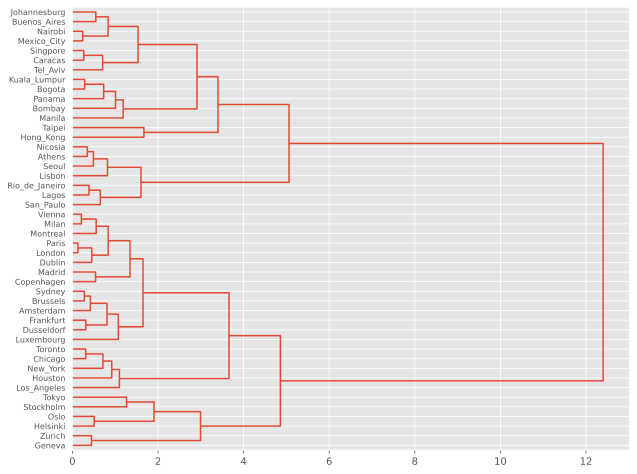

In [59]:
plt.figure(figsize=(10, 8))
dn = dendrogram(Z,
                color_threshold=-1,
                labels=df.index.tolist(),
                orientation='right',
                )

Предварительно рассмотрев дендрограмму, можно предположить, что кластеров у нас либо 2, либо 4. Воспользуемся вспомогательным инструментом для определения количества кластеров.

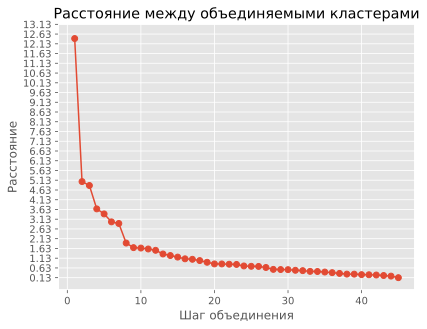

In [60]:
dist = Z[:, 2]
dist
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Расстояние между объединяемыми кластерами')
plt.xlabel('Шаг объединения')
plt.ylabel('Расстояние')

plt.yticks(np.arange(min(dist[::-1]), max(dist[::-1])+1, 0.5))

plt.show()

Проанализировав график "Каменистая осыпь" остановимся на количестве 4 кластера и обозначим высоту h = 4.1 (чтоб не путаться где что)

In [61]:
h = 4.1

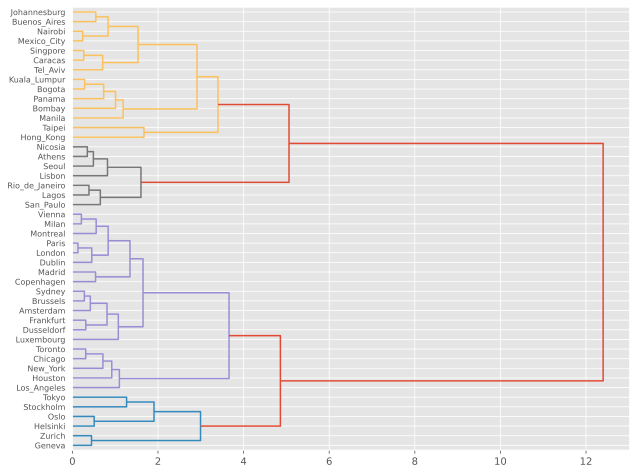

In [62]:
plt.figure(figsize=(10, 8))
dn = dendrogram(Z,
                color_threshold=4.1,
                labels=df.index.tolist(),
                orientation='right',
                )

Мы получили 4 кластера, добавим столбец кластера в наш набор данных

In [63]:
df['cluster'] = fcluster(Z, h, criterion='distance')

In [64]:
print(df.sort_values(by = 'cluster'))

                  Work  Price  Salary  cluster
City                                          
Zurich          1868.0  100.0   100.0        1
Tokyo           1880.0  115.0    68.0        1
Stockholm       1805.0  111.3    39.2        1
Oslo            1583.0  115.5    63.7        1
Geneva          1880.0   95.9    90.3        1
Helsinki        1667.0  113.6    66.6        1
Toronto         1888.0   70.2    58.2        2
Sydney          1668.0   70.8    52.1        2
Paris           1744.0   81.6    45.9        2
New_York        1942.0   83.3    65.8        2
Montreal        1827.0   72.7    56.3        2
Milan           1773.0   82.0    53.3        2
Madrid          1710.0   93.8    50.0        2
Vienna          1780.0   78.0    51.3        2
Los_Angeles     2068.0   79.8    65.2        2
London          1737.0   84.2    46.2        2
Amsterdam       1714.0   65.6    49.0        2
Luxembourg      1768.0   71.1    71.1        2
Brussels        1708.0   73.8    50.5        2
Chicago      

In [65]:
df.groupby('cluster').size()

cluster
1     6
2    19
3     7
4    14
dtype: int64

In [66]:
df.groupby('cluster').mean().round(2)

,Work,Price,Salary
cluster,,,
1,1780.50,108.55,71.30
2,1792.00,77.53,55.16
3,1798.86,50.94,19.21
4,2082.36,53.12,14.91


# Интерпретация кластеров
1) Кластер под номером 1(Мегаполисы): Города с нормальной рабочей неделей, но с огромными ценами при хорошей зарплате. В этот кластер попали мегаполисы и столицы развитых стран.
2) Кластер под номером 2(Города среднего достатка): Этот кластер представляют города со стандартной рабочей неделей, ценами чуть выше среднего и средними зарплатами. Скорее всего региональные центры развитых стран.
3) Кластер под номером 3(бедные города): Города с достаточно низкими заработными платами, но с достаточно стандартным количеством рабочих часов. Сюда попали достаточно бедные города, но в которых у людей есть выходные дни.
4) Кластер под номером 4(бедные города с переработками): Города, в которых количество рабочих часов значительно больше, чем во всех остальных. При это самая низкая оплата труда за час работы. Скорее всего представители этого кластера - бедные города бедных стран.

# Кластерный анализ методом KMeans

In [67]:
df_KM.shape

(46, 3)

In [68]:
df_KM.head(5)

,Work,Price,Salary
City,,,
Amsterdam,1714.0,65.6,49.0
Athens,1792.0,53.8,30.4
Bogota,2152.0,37.9,11.5
Bombay,2052.0,30.3,5.3
Brussels,1708.0,73.8,50.5


Используем ранее очищенные и стандартизированные данные

In [69]:
X_KM.head()

,Work,Price,Salary
City,,,
Amsterdam,-0.962166,-0.212712,0.386095
Athens,-0.509827,-0.770489,-0.373488
Bogota,1.577891,-1.522069,-1.145323
Bombay,0.997969,-1.881316,-1.398517
Brussels,-0.996961,0.174896,0.447351


#### Данные успешно импортированы, определили количество столбцов и строк, а также вывели данные для проверки

Импортируем библиотеку и глушим ошибки

In [70]:
from sklearn.cluster import KMeans

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "2"
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak*")

Построим график "Каменистая осыпь" для 10 кластеров и попытаемся определить место излома

In [83]:
K = range(1, 15)

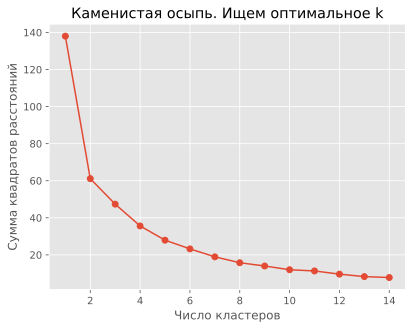

In [84]:
models = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_KM) for k in K]
dist = [model.inertia_ for model in models] # inertia - Ws

# Строим график каменистая осыпь
plt.plot(K, dist, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Каменистая осыпь. Ищем оптимальное k');

Возьмем число кластеров, равное 2

In [78]:
model = KMeans(n_clusters=2, random_state=42, max_iter=300, n_init=10,
               verbose=0, tol=0.0001 )
model.fit(X)
df['cluster'] = model.labels_

In [81]:
df.groupby('cluster').size()

cluster
0    21
1    25
dtype: int64

In [82]:
df.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
0,1987.857143,52.395238,16.347619
1,1789.240000,84.972000,59.032000


В данном случае кластеризации у нас получилось два больших кластера

1) В первый кластер попали города из развивающихся стран, где люди в среднем больше работают, но зарабатывают относительно немного. Цены на товары средние
2) Во второй кластер попали более богатые города, с менее загруженной рабочей неделей. Зарплаты примерно на среднем уровне, цены достаточно высокие

Хоть данных и немного, но 2 кластера кажется слишком мало и поэтому мы упускаем часть информации, по которой города отличаются.

Попробуем вернуться к 4 кластерам, но для начала рассмотрим переходный вариант с 3мя кластерами

In [85]:
model = KMeans(n_clusters=3, random_state=42, max_iter=300, n_init=10,
               verbose=0, tol=0.0001 )
model.fit(X)
df['cluster'] = model.labels_

In [86]:
df.groupby('cluster').size()

cluster
0    11
1    25
2    10
dtype: int64

по количеству элементов в кластере видно, что один из двух предыдущих кластеров ровненько раскололся на два

In [87]:
df.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
0,1855.454545,50.781818,16.590909
1,1789.240000,84.972000,59.032000
2,2133.500000,54.170000,16.080000


Кластер с богатыми городами остался нетронутым

А вот кластер с бедными городами разделился. У нас так же остались бедные города в кластере 0, в среднем они конечно работают меньше, но зарплаты такие же

Новый кластер 2 представляют города с жестокими условиями труда, более 2.1 тысяч часов работы, хотя цены даже выше чем в просто бедных городах. Предположим что это города бедных стран, возможно находящихся в состоянии кризиса.

Продолжим разбиение до 4 кластеров

In [91]:
model = KMeans(n_clusters=4, random_state=42, max_iter=300, n_init=10,
               verbose=0, tol=0.0001 )
model.fit(X)
df['cluster'] = model.labels_

In [92]:
df.groupby('cluster').size()

cluster
0    17
1    10
2     8
3    11
dtype: int64

теперь у нас 4 кластера. Кластер с богатыми городами разбился на 2. Посмотрим в чем нашел отличия между ними алгоритм.

In [93]:
df.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
0,1801.235294,75.758824,55.005882
1,2133.500000,54.170000,16.080000
2,1763.750000,104.550000,67.587500
3,1855.454545,50.781818,16.590909


In [98]:
df.sort_values('cluster')

,Work,Price,Salary,cluster
City,,,,
Amsterdam,1714.0,65.6,49.0,0
Toronto,1888.0,70.2,58.2,0
Sydney,1668.0,70.8,52.1,0
Paris,1744.0,81.6,45.9,0
New_York,1942.0,83.3,65.8,0
Montreal,1827.0,72.7,56.3,0
Milan,1773.0,82.0,53.3,0
Vienna,1780.0,78.0,51.3,0
Los_Angeles,2068.0,79.8,65.2,0


Кластер с богатыми городами разбился на такие же богатые города и на мегаполисы. Города с самыми высокими зп, но в то же время с очень высокими ценами.

В целом интерпретация такая же как и при иерархическом кластерном анализе.